In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
acquisition_0d5_path = "data/acquisition/20240529_01_hermes_fm1_LV0d5.fits"
acquisition_hk_path = "data/acquisition/20240529_cal/fm1/01/hk/20240529_01_hermes_fm1.hk"

## Temperatures

We give a look to the temperatures to assess the right calibration file to use.

<Axes: xlabel='Time [s]', ylabel='Temperature [C]'>

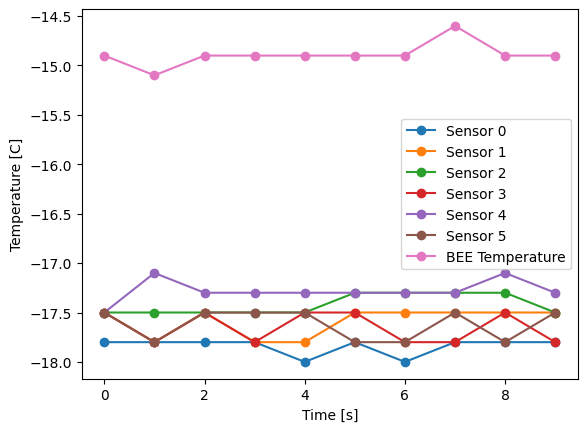

In [3]:
from astropy.io import fits

with fits.open(acquisition_hk_path) as f:
    hk_data = f[1].data
    
temp_array = np.hstack((hk_data["FEETEMPP"], np.expand_dims(hk_data["BEETEMPP"], axis=1)))
temp_df = pd.DataFrame(temp_array, columns=[f"Sensor {i}" for i in range(6)] + ["BEE Temperature"])
temp_df.plot(ylabel="Temperature [C]", xlabel="Time [s]", marker="o")

## Calibration

We calibrate with no filters.

In [4]:
from functools import partial

from source.calibrate import ImportedCalibration
from source.io import read_sdd_calibration_report, read_lightout_report, pandas_from_LV0d5
from source.eventlist import preprocess

class FakeConsole:
    def __init__(self):
        return 
    
    def log(self, msg):
        pass

configuration = {"binning": 10}
model="fm1"
sdd_calibration = read_sdd_calibration_report(Path("data/fm1_m20deg_standard_calibration/report_cal.xlsx"))
slo_calibration = read_lightout_report(Path("data/fm1_m20deg_standard_calibration/report_slo.xlsx")) 

def _calibrate_data(datafile, model, sdd_calibration, slo_calibration, configuration):
    data = pandas_from_LV0d5(datafile)
    data, waste = preprocess(data, model=model, filter_spurious=False, filter_retrigger=0)
    calibration = ImportedCalibration(
        model=model, 
        configuration=configuration,
        sdd_calibration=sdd_calibration,
        lightoutput=slo_calibration,
        console=FakeConsole(),
    )
    return calibration(data), calibration


calibrate_data = partial(_calibrate_data, model=model, sdd_calibration=sdd_calibration, slo_calibration=slo_calibration, configuration=configuration)

We calibrate the data.

In [5]:
data_df, calibration = calibrate_data(acquisition_0d5_path)

In [6]:
data_df

,ENERGY,TIME,ELECTRONS,EVTYPE,CHN,QUADID
0,47.522858,7.502779e+07,13019.960938,X,0,D
1,55.012386,7.502779e+07,15071.886719,X,15,D
2,98.473297,7.502779e+07,26978.984375,X,13,B
3,132.712967,7.502779e+07,36359.714844,X,13,B
4,35.849976,7.502779e+07,9821.911133,X,27,C
...,...,...,...,...,...,...
11811,162.830170,7.502780e+07,44611.003906,X,9,D
11812,158.646362,7.502780e+07,43464.753906,X,16,D
11813,55.171036,7.502780e+07,15115.351562,X,0,D
11814,175.314545,7.502780e+07,48031.382812,X,30,D


# Lightcurve and retrigger search

This is the lightcurve with a binning size of about 1/10 of a second. Rather unremarkable.

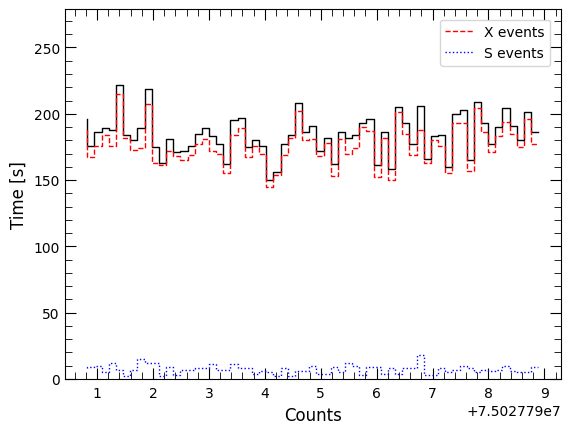

In [37]:
binning = 0.128
bins = np.arange(data_df["TIME"].min(), data_df["TIME"].max(), binning)
counts, _ = np.histogram(data_df["TIME"], bins=bins)
counts_x, _ = np.histogram(data_df[data_df["EVTYPE"]=="X"]["TIME"], bins=bins)
counts_s, _ = np.histogram(data_df[data_df["EVTYPE"]=="S"]["TIME"], bins=bins)
plt.step(bins[:-1], counts)
plt.step(bins[:-1], counts_x, label="X events")
plt.step(bins[:-1], counts_s, label="S events")
plt.ylim(bottom=0, top=counts.mean() + 7 * np.sqrt(counts.mean()))
plt.ylabel("Time [s]")
plt.xlabel("Counts")
plt.legend()
plt.show()


Shortening the bin size we start to find something more anomalous.

In [8]:
binning = 0.016
bins = np.arange(data_df["TIME"].min(), data_df["TIME"].max(), binning)
counts, _ = np.histogram(data_df["TIME"], bins=bins)

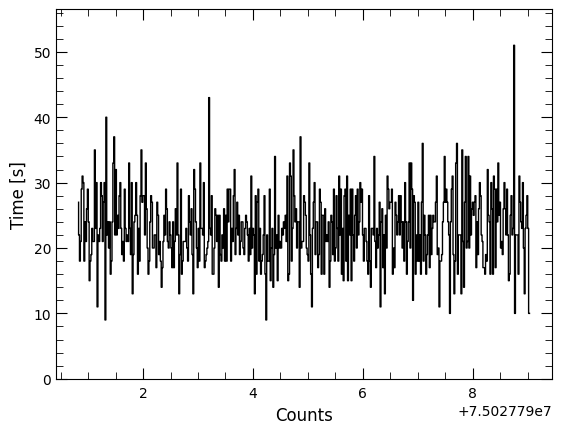

In [9]:
plt.step(bins[:-1], counts)
plt.ylim(bottom=0, top = counts.mean() + 7*np.sqrt(counts.mean()))
plt.ylabel("Time [s]"); plt.xlabel("Counts")
plt.show()

The qq plot shows that counts follow a Poisson distribution with mean equal to the acquisition mean rate, but for two-three points where we observed an excess of counts. 

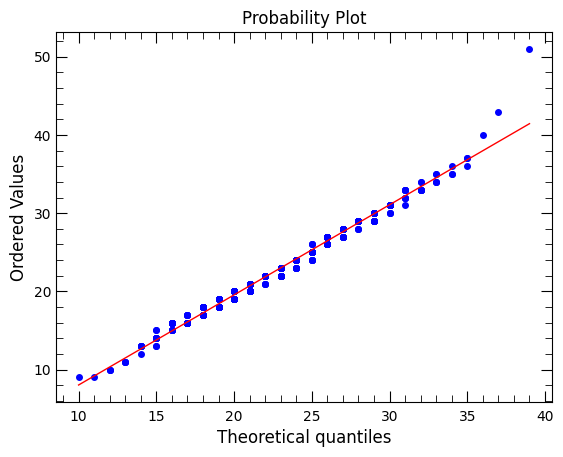

In [10]:
import scipy.stats as stats

pdf = stats.poisson(counts.mean())
res = stats.probplot(counts, dist=pdf, plot=plt)

We isolate the times of the anomalous bins.

In [11]:
high_counts_times = bins[np.argsort(counts)][::-1][:3]
high_counts_counts = counts[np.argsort(counts)][::-1][:3]

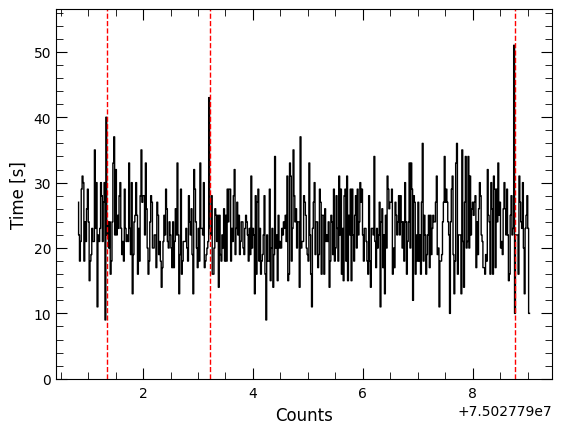

In [12]:
plt.step(bins[:-1], counts)
for t in high_counts_times:
    plt.axvline(t, color="red", linestyle="dashed")
plt.ylim(bottom=0, top = counts.mean() + 7*np.sqrt(counts.mean()))
plt.ylabel("Time [s]"); plt.xlabel("Counts")
plt.show()

Let's take a closer look to the anomalous bin which counted the most. This is the relevant data slice:

In [13]:
t0 = high_counts_times[0]
mask = (data_df["TIME"] >= t0) & (data_df["TIME"] < t0 + binning)
data_df[mask]

,ENERGY,TIME,ELECTRONS,EVTYPE,CHN,QUADID
11386,20.177895,7.502780e+07,5528.189941,X,22,C
11387,35.348873,7.502780e+07,9684.622070,X,5,B
11388,123.017761,7.502780e+07,33703.496094,X,2,B
11389,5.345783,7.502780e+07,1464.598022,X,10,B
11390,5.282213,7.502780e+07,1447.181519,X,10,B
11391,65.961548,7.502780e+07,18071.656250,X,31,C
11392,6.055655,7.502780e+07,1659.083374,X,10,B
11393,6.214581,7.502780e+07,1702.624878,X,10,B
11394,6.251664,7.502780e+07,1712.784546,X,10,B
11395,6.288746,7.502780e+07,1722.944214,X,10,B


We can see there are many consecutive trigger from a single channel, B10.

In [14]:
end, start = 11412, 11389
duration = data_df[mask]["TIME"].loc[end] - data_df[mask]["TIME"].loc[start]
num = end - start
print(f"Episode lasted {duration:.4f}s and comprised {num} events over channel B10")

Episode lasted 0.0026s and comprised 23 events over channel B10


The delay between these events are short given the count rate but a bit all-over the place and higher than 20 us.

In [15]:
np.diff(data_df.iloc[start:end]["TIME"]) * 10 ** 6 # in microseconds

array([ 75.20616055,  31.39674664, 305.60791492, 154.59954739,
        35.79258919, 328.89842987, 222.20611572,  93.89221668,
       188.20166588,  24.19948578,  80.80899715, 202.78990269,
        43.70510578,  54.70216274, 143.39387417,  48.20525646,
        95.79956532,  83.10377598, 125.39327145,  34.79421139,
        66.71249866,  94.19023991])

In [16]:
import scipy.special as sps

def significance(n, b):
    pvalue = sps.pdtrc(n, b)
    # converts to standard deviations
    stdevs = -sps.ndtri(pvalue)
    return stdevs

print(f"The significance of the retrigger bin is {significance(high_counts_counts[0], counts.mean()):.3f} sigma")

The significance of the retrigger bin is 5.139 sigma


Let's look at the significance of the bin where we observed the second-highest count.

In [17]:
pvalue_sigma = significance(high_counts_counts[1], counts.mean())
norm_dist = stats.norm(loc=counts.mean(), scale=np.sqrt(counts.mean()))
print(f"The significance of the bin count is {pvalue_sigma:.3f} sigma, meaning that we should expect values more extreme than that once every {(_freq := 1/(1 - stats.norm.cdf(pvalue_sigma))):.0f} counts ({100 * len(counts) / _freq:.2f}%, given the length of the acquisition).")

The significance of the bin count is 3.839 sigma, meaning that we should expect values more extreme than that once every 16165 counts (3.18%, given the length of the acquisition).


This is not that surprising but still worth to explore.

In [18]:
t1 = high_counts_times[1]
mask = (data_df["TIME"] >= t1) & (data_df["TIME"] < t1 + binning)
data_df[mask]

,ENERGY,TIME,ELECTRONS,EVTYPE,CHN,QUADID
3436,147.043777,7.502779e+07,40285.964844,X,16,D
3437,163.612717,7.502779e+07,44825.402344,X,26,B
3438,5.982782,7.502779e+07,1639.118286,X,27,B
3439,30.807825,7.502779e+07,8440.500000,X,23,B
3440,10.507672,7.502779e+07,2878.814209,X,29,D
3441,43.993275,7.502779e+07,12052.952148,X,29,D
3442,28.956133,7.502779e+07,7933.187012,X,1,B
3443,82.758858,7.502779e+07,22673.658203,X,10,B
3444,170.400375,7.502779e+07,46685.031250,X,27,D
3445,27.032570,7.502779e+07,7406.183594,X,2,B


It's interesting to note how this bins host some of the most energetic photons we have seen. Maybe a CR?

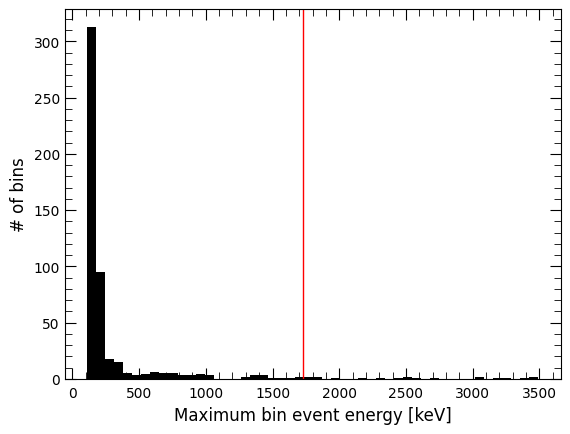

In [19]:
bin_mean_energies = [data_df[(data_df["TIME"] >= bin_start) & (data_df["TIME"] < bin_end)]["ENERGY"].quantile(0.95) for bin_start, bin_end in zip(bins, bins[1:])]

plt.hist(bin_mean_energies, bins=50)
plt.axvline(data_df[mask]["ENERGY"].quantile(0.95), color="red")
plt.ylabel("# of bins")
plt.xlabel("Maximum bin event energy [keV]")
plt.show()

The last bin is less interesting.

In [20]:
pvalue_sigma = significance(high_counts_counts[2], counts.mean())
norm_dist = stats.norm(loc=counts.mean(), scale=np.sqrt(counts.mean()))
print(f"The significance of the bin count is {pvalue_sigma:.3f} sigma, meaning that we should expect values more extreme than that once every {(_freq := 1/(1 - stats.norm.cdf(pvalue_sigma))):.0f} counts ({100 * len(counts) / _freq:.2f}%, given the length of the acquisition).")

The significance of the bin count is 3.330 sigma, meaning that we should expect values more extreme than that once every 2300 counts (22.35%, given the length of the acquisition).


# Channels map

There is some left to right symmetry in the channel maps.

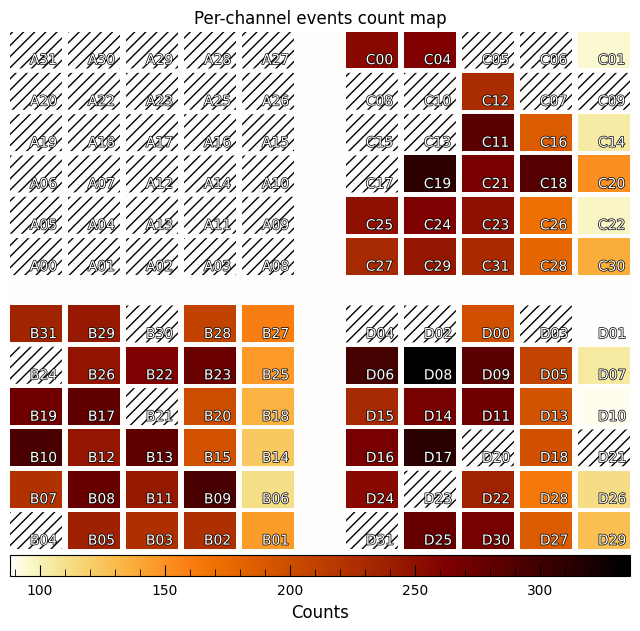

In [21]:
from source.plot import mapcounts

fig, ax = mapcounts(calibration.count(), calibration.detector.map)
ax.set_title("Per-channel events count map")
plt.show()

# Spectra

The calibrated spectra are peculiar. They are rather flat. The shape of the X and S spectra is also rather similiar. There are a number of high-energy spikes in the X domain, but these are probably just saturated events observed over different channels.

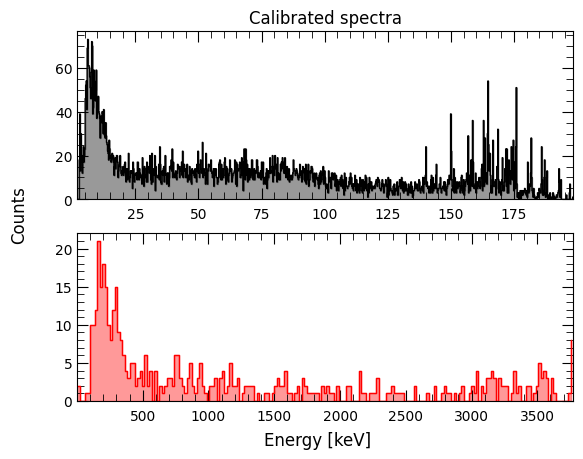

In [22]:
from source.plot import spectrum_xs

bins_x = np.linspace(2, data_df[data_df["EVTYPE"] == "X"]["ENERGY"].max(), 1000)
bins_s = np.linspace(2, data_df[data_df["EVTYPE"] == "S"]["ENERGY"].max(), 200)
fig, ax = spectrum_xs(data_df, {}, {}, bins_x=bins_x, bins_s=bins_s)

There are much more X events than S. Consider that a fraction of the S events are there just by chance (an incidental trigger with multiplicity 2). Given the similiarity between the spectra the fraction of true S events could be very low.

In [23]:
data_df.groupby("EVTYPE").size()

EVTYPE
S      464
X    11352
dtype: int64

Let's try to check how natural these high-energy X events are.

First, the proportion of energetic X events is consistent across different quadrants.

In [24]:
from statsmodels.stats.proportion import proportion_confint

threshold = 25 # keV
for quad in "BCD":
    mask = (data_df["EVTYPE"] == "X") & (data_df["QUADID"] == quad)
    n_ = len(data_df[mask & (data_df["ENERGY"] > threshold)])
    quad_n = len(data_df[mask])
    conf_lo, conf_hi = proportion_confint(count=n_, nobs=quad_n)
    print(f"The {100 * n_/quad_n:.1f}% of the X events observed of {quad} have energies greater than {threshold} keV")
    print(f"Wald confidence interval (95%): {conf_lo:.2f}, {conf_hi:.2f}")

The 74.2% of the X events observed of B have energies greater than 25 keV
Wald confidence interval (95%): 0.73, 0.75
The 70.1% of the X events observed of C have energies greater than 25 keV
Wald confidence interval (95%): 0.68, 0.72
The 71.9% of the X events observed of D have energies greater than 25 keV
Wald confidence interval (95%): 0.70, 0.73


Let's try to plot the per-channel distribution of the X events with energies greater than 25 keV. The left-to-right asymettry is evident. Note that the scintillator are laid bottom to top.

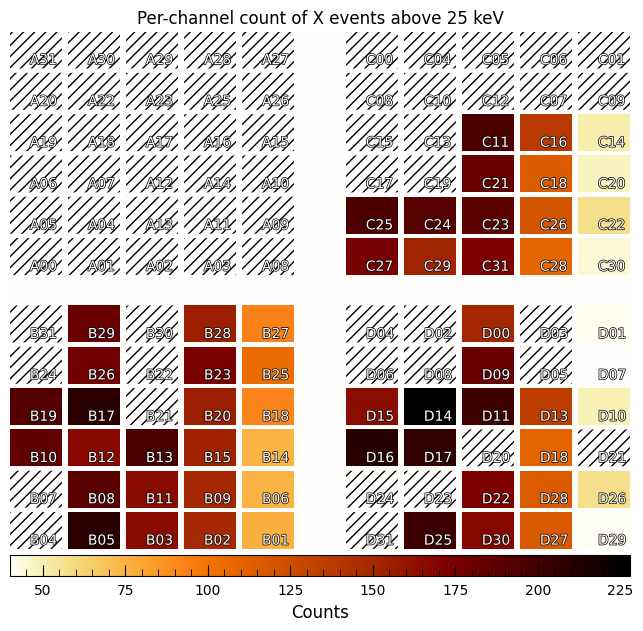

In [26]:
from source.eventlist import perchannel_counts

mask = (data_df["EVTYPE"] == "X") & (data_df["ENERGY"] > 25.)
fig, ax = mapcounts(perchannel_counts(data_df[mask], calibration.channels), calibration.detector.map, title="Per-channel count of X events above 25 keV")

The same asimmetry is not visible when plotting the per-channel distribution of X events below 25 keV. This is weird.

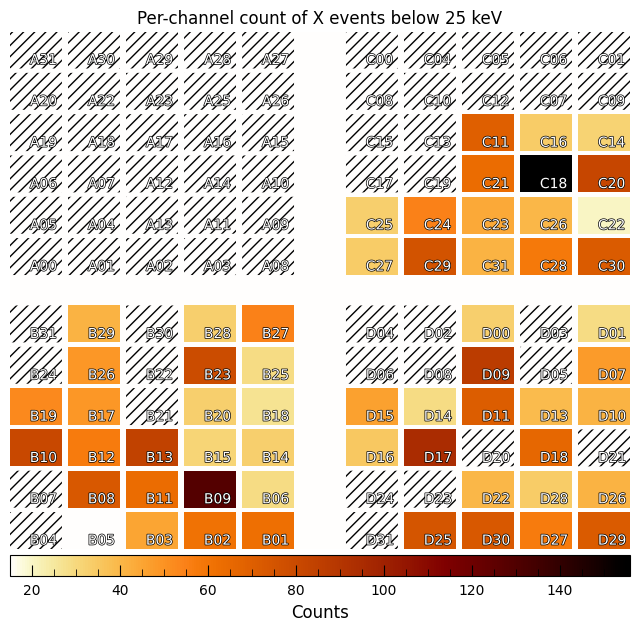

In [27]:
mask = (data_df["EVTYPE"] == "X") & (data_df["ENERGY"] < 25.)
fig, ax = mapcounts(perchannel_counts(data_df[mask], calibration.channels), calibration.detector.map, title="Per-channel count of X events below 25 keV")

Let's now check the time delays between different events. 
We compute the delays separately for each quadrant, and then aggregate them.

In [28]:
mask = (data_df["EVTYPE"] == "X") & (data_df["ENERGY"] > 25.)
delays = {}
for quad in "BCD":
    delays[quad] = np.diff(data_df[mask & (data_df["QUADID"] == quad)]["TIME"])

aggregated_delays = np.concatenate([*delays.values()])

Let's plot the histograms of the delays quadrant by quadrant. All looks exponential. Different slopes are likely due to different number of on channels. 

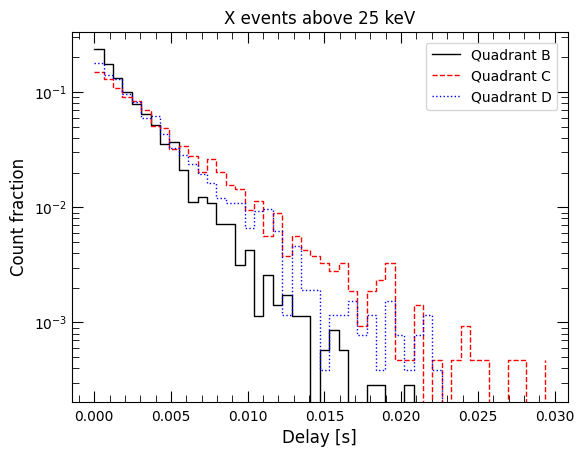

In [29]:
bins = np.linspace(0, .03, 50)
for quad in "BCD":
    counts, bins = np.histogram(delays[quad], bins=bins)
    plt.step(bins[:-1], counts/ np.sum(counts), label=f"Quadrant {quad}", where="post")
plt.legend()
plt.semilogy()
plt.ylabel("Count fraction")
plt.xlabel("Delay [s]")
plt.title("X events above 25 keV")
plt.show()

Exponential distribution is also very apparent from the aggregated delays.

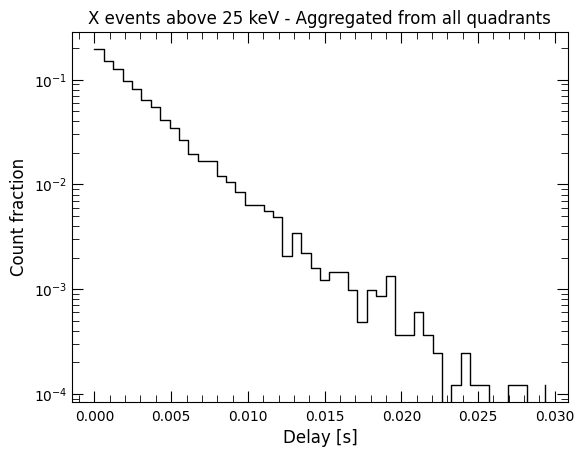

In [30]:
bins = np.linspace(0, .03, 50)
counts, bins = np.histogram(aggregated_delays, bins=bins)
plt.step(bins[:-1], counts/ np.sum(counts), where="post")
plt.semilogy()
plt.ylabel("Count fraction")
plt.xlabel("Delay [s]")
plt.title("X events above 25 keV - Aggregated from all quadrants")
plt.show()

The qqplot looks convincing too. We see a bit of excess in longer delays.

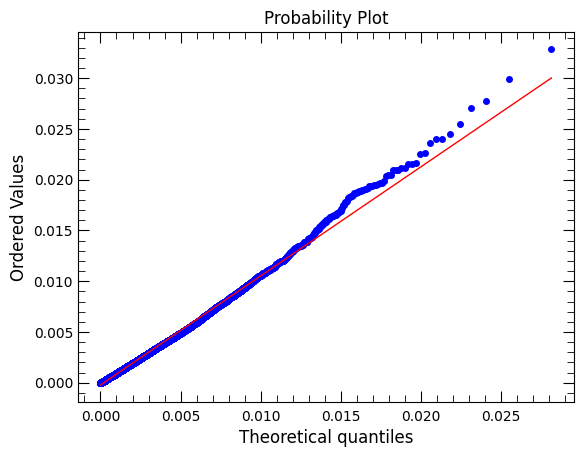

In [31]:
import scipy.stats as stats

pdf = stats.expon(scale=aggregated_delays.mean())
res = stats.probplot(aggregated_delays, dist=pdf, plot=plt)